# GARCH Model for Bitcoin Price Prediction

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) is a statistical model used for analyzing and forecasting volatility in time series data, particularly effective for financial data like Bitcoin prices.


### Import thư viện


In [40]:
%pip install arch seaborn
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from arch import arch_model
from arch.univariate import GARCH, ConstantMean
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from typing import Tuple
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Bitcoin Dataset


### Import csv


In [41]:
# Đọc file Bitcoin
file_path = "D:\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\Bitcoin Historical Data.csv"

data = pd.read_csv(file_path)

# Loại bỏ dấu phẩy và chuyển đổi thành float
for col in ['Price', 'Open']:
    data[col] = data[col].str.replace(',', '', regex=False).astype(float)

# Xử lý cột 'Vol.' chứa hậu tố 'K', 'M', 'B'
def convert_volume(val):
    val = str(val).replace(',', '').strip()
    if 'K' in val:
        return float(val.replace('K', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '')) * 1_000_000
    elif 'B' in val:
        return float(val.replace('B', '')) * 1_000_000_000
    else:
        return float(val)

data['Vol.'] = data['Vol.'].apply(convert_volume)

# Đổi Date sang datetime và đặt làm index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Select 3 columns: Price, Open, Vol
data_features = data[['Price', 'Open', 'Vol.']].copy()

print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst 5 rows:")
print(data[['Price', 'Open', 'Vol.']].head())
print(f"Tổng số dữ liệu: {len(data)} dòng")

Data shape: (3370, 6)
Columns: ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

First 5 rows:
            Price   Open     Vol.
Date                             
2016-03-10  415.8  412.8  55740.0
2016-03-11  419.1  415.8  60630.0
2016-03-12  410.4  419.1  59640.0
2016-03-13  412.4  410.4  34980.0
2016-03-14  414.3  412.4  49330.0
Tổng số dữ liệu: 3370 dòng


### Chia 7:3


#### Chuẩn bị dữ liệu cho GARCH


In [42]:
# Tính log returns cho GARCH model
data['Log_Return'] = np.log(data['Price'] / data['Price'].shift(1))
data['Simple_Return'] = data['Price'].pct_change()

# Loại bỏ giá trị NaN
data_clean = data.dropna()

print(f"Dữ liệu sau khi tính returns: {len(data_clean)} dòng")
print("\nThống kê mô tả của Log Returns:")
print(data_clean['Log_Return'].describe())

# Kiểm tra tính dừng của chuỗi returns
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'\n{name} - Kiểm định ADF:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("✓ Chuỗi dừng (stationary)")
    else:
        print("✗ Chuỗi không dừng (non-stationary)")
    return result[1] <= 0.05

# Kiểm tra tính dừng
is_stationary = check_stationarity(data_clean['Log_Return'], 'Log Returns')

Dữ liệu sau khi tính returns: 3369 dòng

Thống kê mô tả của Log Returns:
count    3369.000000
mean        0.001638
std         0.036633
min        -0.497278
25%        -0.012538
50%         0.001340
75%         0.017010
max         0.227602
Name: Log_Return, dtype: float64

Log Returns - Kiểm định ADF:
ADF Statistic: -40.329533
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
✓ Chuỗi dừng (stationary)


In [43]:
# Chia dữ liệu train/test theo tỷ lệ 7:3
train_size = int(len(data_clean) * 0.7)
train_data = data_clean.iloc[0:train_size].copy()
test_data = data_clean.iloc[train_size:].copy()

# Lấy returns cho train và test
train_returns = train_data['Log_Return'].values
test_returns = test_data['Log_Return'].values

print(f"Kích thước tập train: {len(train_data)}")
print(f"Kích thước tập test: {len(test_data)}")
print(f"Train returns shape: {train_returns.shape}")
print(f"Test returns shape: {test_returns.shape}")

Kích thước tập train: 2358
Kích thước tập test: 1011
Train returns shape: (2358,)
Test returns shape: (1011,)


#### Xây dựng mô hình GARCH


In [44]:
def build_garch_model(returns_data, p=1, q=1):
    """
    Xây dựng mô hình GARCH(p,q)
    
    Args:
        returns_data: Chuỗi returns
        p: Order của GARCH term
        q: Order của ARCH term
    
    Returns:
        Fitted GARCH model
    """
    # Nhân returns với 100 để có scale phù hợp
    returns_scaled = returns_data * 100
    
    # Tạo mô hình GARCH
    model = arch_model(returns_scaled, vol='Garch', p=p, q=q, dist='normal')
    
    # Fit mô hình
    fitted_model = model.fit(disp='off')
    
    return fitted_model, model

def evaluate_garch_model(fitted_model):
    """
    Đánh giá mô hình GARCH
    """
    print("="*50)
    print("THÔNG TIN MÔ HÌNH GARCH")
    print("="*50)
    print(fitted_model.summary())
    
    # Kiểm tra phần dư
    residuals = fitted_model.resid
    standardized_residuals = residuals / fitted_model.conditional_volatility
    
    # Ljung-Box test cho phần dư
    lb_result = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(f"\nLjung-Box test p-value (residuals): {lb_result['lb_pvalue'].iloc[-1]:.4f}")
    
    # Ljung-Box test cho phần dư bình phương
    lb_result_sq = acorr_ljungbox(residuals**2, lags=10, return_df=True)
    print(f"Ljung-Box test p-value (squared residuals): {lb_result_sq['lb_pvalue'].iloc[-1]:.4f}")
    
    return fitted_model.aic, fitted_model.bic

In [45]:
def forecast_garch_prices(fitted_model, initial_price, forecast_horizon):
    """
    Dự đoán giá sử dụng GARCH model
    
    Args:
        fitted_model: Mô hình GARCH đã fit
        initial_price: Giá ban đầu
        forecast_horizon: Số ngày dự đoán
    
    Returns:
        Dự đoán giá và volatility
    """
    # Forecast returns và volatility
    forecast = fitted_model.forecast(horizon=forecast_horizon)
    
    # Lấy mean và variance dự đoán
    forecast_mean = forecast.mean.iloc[-1].values / 100  # Scale về decimal
    forecast_variance = forecast.variance.iloc[-1].values / 10000  # Scale về decimal
    
    # Tạo random walks cho price prediction
    np.random.seed(42)  # Để kết quả reproducible
    
    predicted_prices = []
    current_price = initial_price
    
    for i in range(forecast_horizon):
        # Sử dụng mean return và add random noise based on predicted volatility
        return_pred = forecast_mean[i] + np.random.normal(0, np.sqrt(forecast_variance[i]))
        current_price = current_price * np.exp(return_pred)
        predicted_prices.append(current_price)
    
    return np.array(predicted_prices), np.sqrt(forecast_variance) * 100

In [46]:
def plot_garch_diagnostics(fitted_model, returns_data, train_data_index):
    """
    Vẽ biểu đồ chẩn đoán cho mô hình GARCH
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Returns và Conditional Volatility
    # Sử dụng index từ train_data thay vì fitted_model.resid.index
    dates = train_data_index
    axes[0, 0].plot(dates, returns_data * 100, alpha=0.7, label='Returns (%)')
    axes[0, 0].plot(dates, fitted_model.conditional_volatility, color='red', label='Conditional Volatility')
    axes[0, 0].set_title('Returns và Conditional Volatility')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Standardized Residuals
    std_resid = fitted_model.resid / fitted_model.conditional_volatility
    axes[0, 1].plot(dates, std_resid)
    axes[0, 1].set_title('Standardized Residuals')
    axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Q-Q Plot
    stats.probplot(std_resid, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Standardized Residuals')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. ACF of Squared Residuals
    from statsmodels.tsa.stattools import acf
    squared_resid = std_resid ** 2
    lags = 20
    acf_vals = acf(squared_resid, nlags=lags)
    axes[1, 1].bar(range(lags+1), acf_vals, alpha=0.7)
    axes[1, 1].set_title('ACF of Squared Standardized Residuals')
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### Huấn luyện mô hình GARCH


Đang huấn luyện mô hình GARCH(1,1)...
THÔNG TIN MÔ HÌNH GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6476.88
Distribution:                  Normal   AIC:                           12961.8
Method:            Maximum Likelihood   BIC:                           12984.8
                                        No. Observations:                 2358
Date:                Mon, Jun 02 2025   Df Residuals:                     2357
Time:                        15:33:28   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu

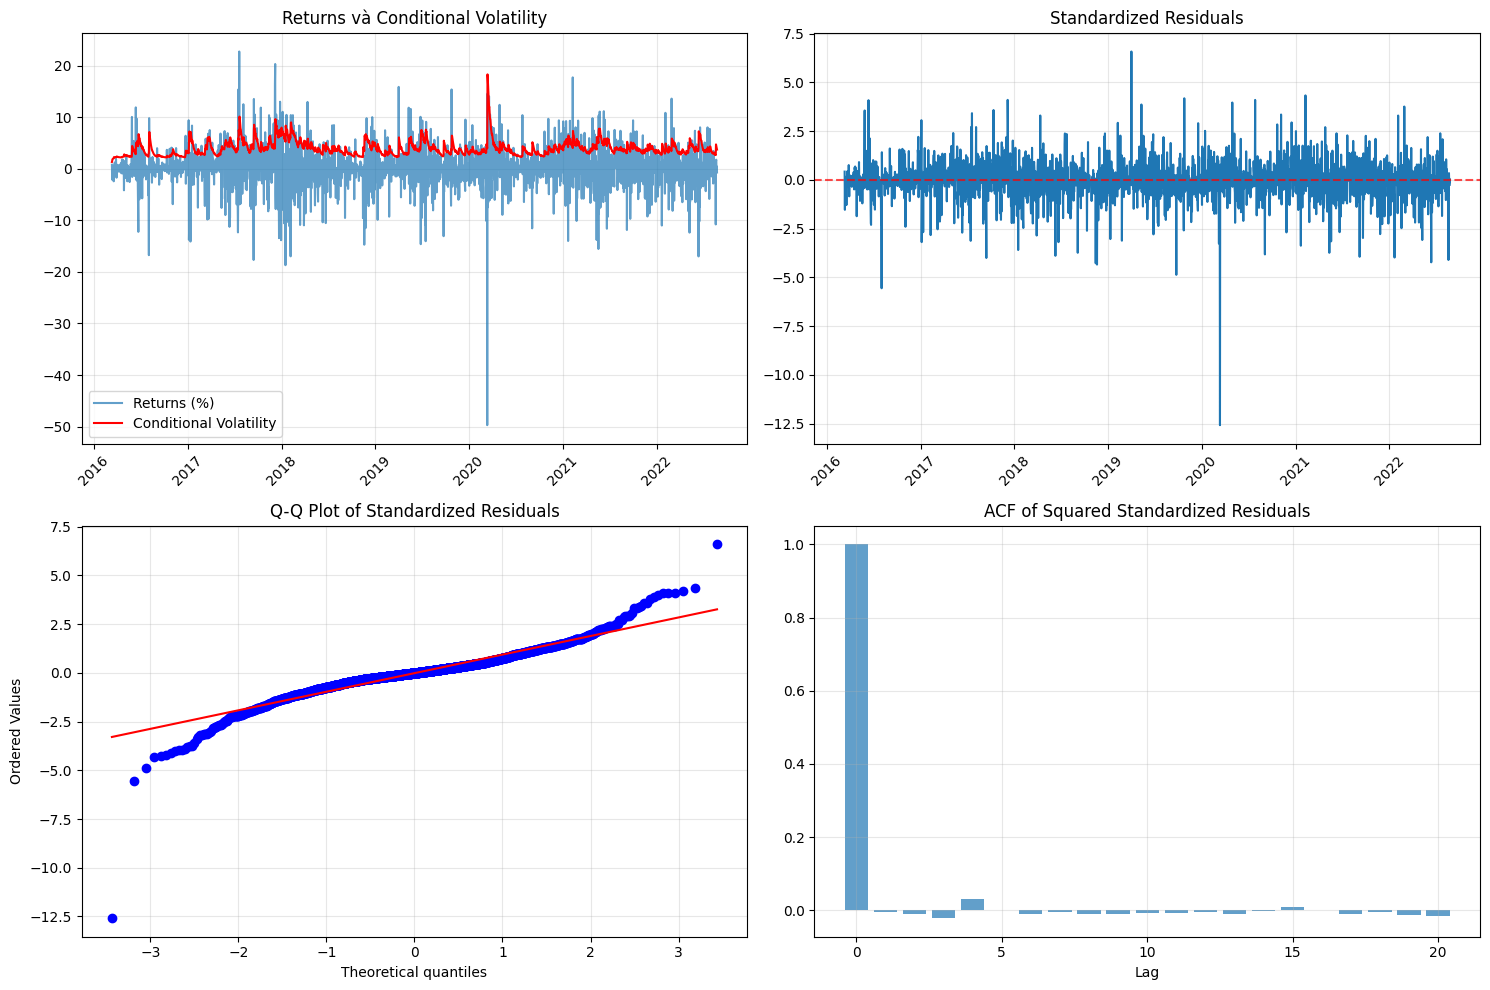

In [47]:
# Fit mô hình GARCH(1,1) cho tập train
print("Đang huấn luyện mô hình GARCH(1,1)...")
fitted_garch, garch_model = build_garch_model(train_returns, p=1, q=1)

# Đánh giá mô hình
aic, bic = evaluate_garch_model(fitted_garch)

# Vẽ biểu đồ chẩn đoán với train_returns và train_data index
plot_garch_diagnostics(fitted_garch, train_returns, train_data.index)

#### Đánh giá mô hình trên tập test


Kết quả đánh giá mô hình GARCH(1,1):
MAPE: 0.55%
MSE: 1572132497.08
RMSE: 39650.13
AIC: 12961.76
BIC: 12984.82


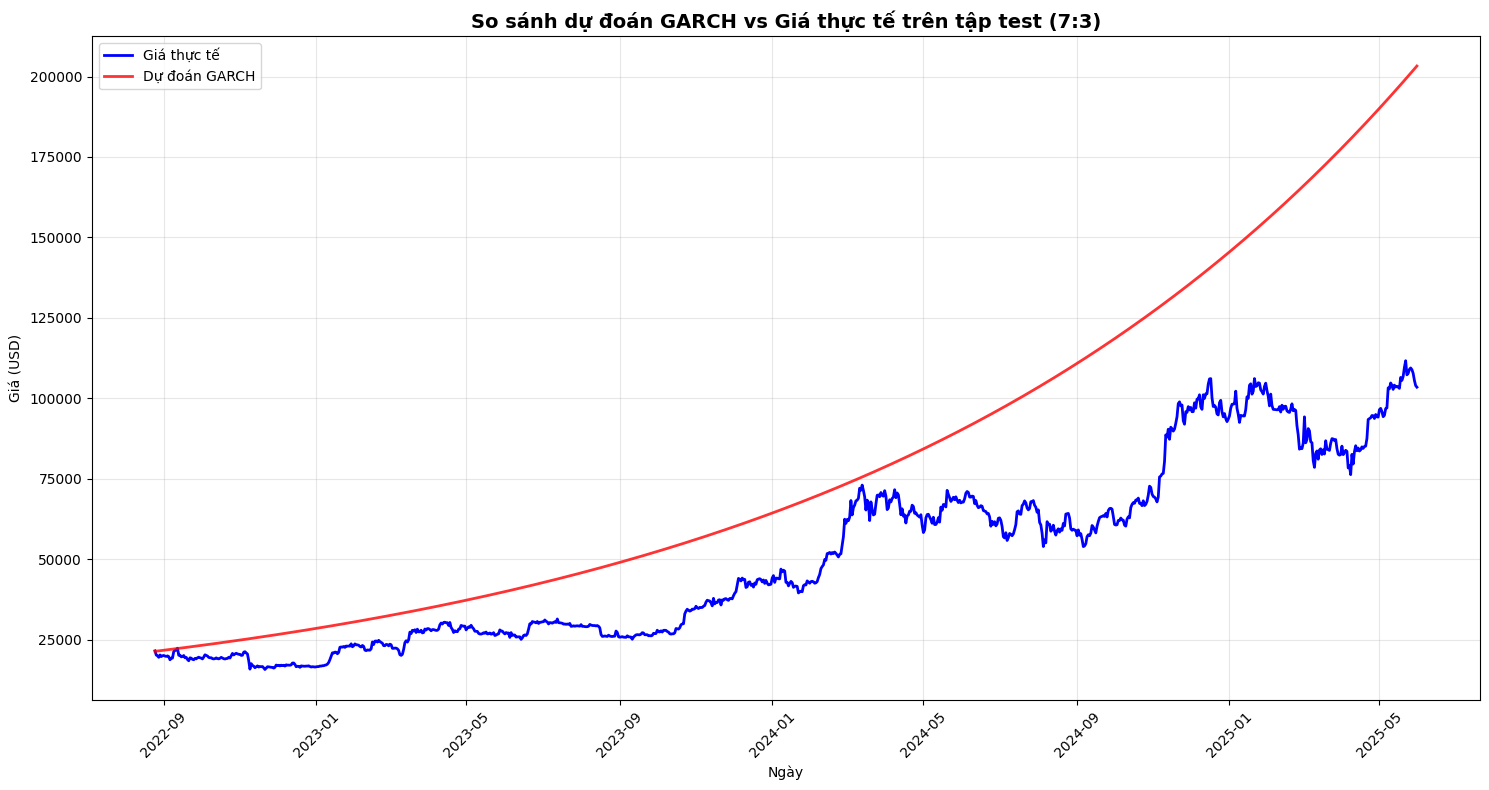

In [48]:
# Dự đoán trên tập test
test_size_days = len(test_data)
last_train_price = train_data['Price'].iloc[-1]

# Forecast cho test period
test_forecast = fitted_garch.forecast(horizon=test_size_days)
forecast_returns = test_forecast.mean.iloc[-1].values / 100
forecast_volatility = np.sqrt(test_forecast.variance.iloc[-1].values) / 100

# Tính predicted prices cho test set
predicted_prices_test = []
current_price = last_train_price

for i in range(test_size_days):
    # Sử dụng predicted return
    predicted_return = forecast_returns[i]
    current_price = current_price * np.exp(predicted_return)
    predicted_prices_test.append(current_price)

predicted_prices_test = np.array(predicted_prices_test)

# Tính metrics
actual_test_prices = test_data['Price'].values
mape = mean_absolute_percentage_error(actual_test_prices, predicted_prices_test)
mse = mean_squared_error(actual_test_prices, predicted_prices_test)
rmse = np.sqrt(mse)

print(f'Kết quả đánh giá mô hình GARCH(1,1):')
print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'AIC: {aic:.2f}')
print(f'BIC: {bic:.2f}')

# Vẽ so sánh dự đoán vs thực tế trên test set
plt.figure(figsize=(15, 8))
plt.plot(test_data.index, actual_test_prices, label='Giá thực tế', linewidth=2, color='blue')
plt.plot(test_data.index, predicted_prices_test, label='Dự đoán GARCH', linewidth=2, color='red', alpha=0.8)
plt.title('So sánh dự đoán GARCH vs Giá thực tế trên tập test (7:3)', fontsize=14, fontweight='bold')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Dự đoán tương lai


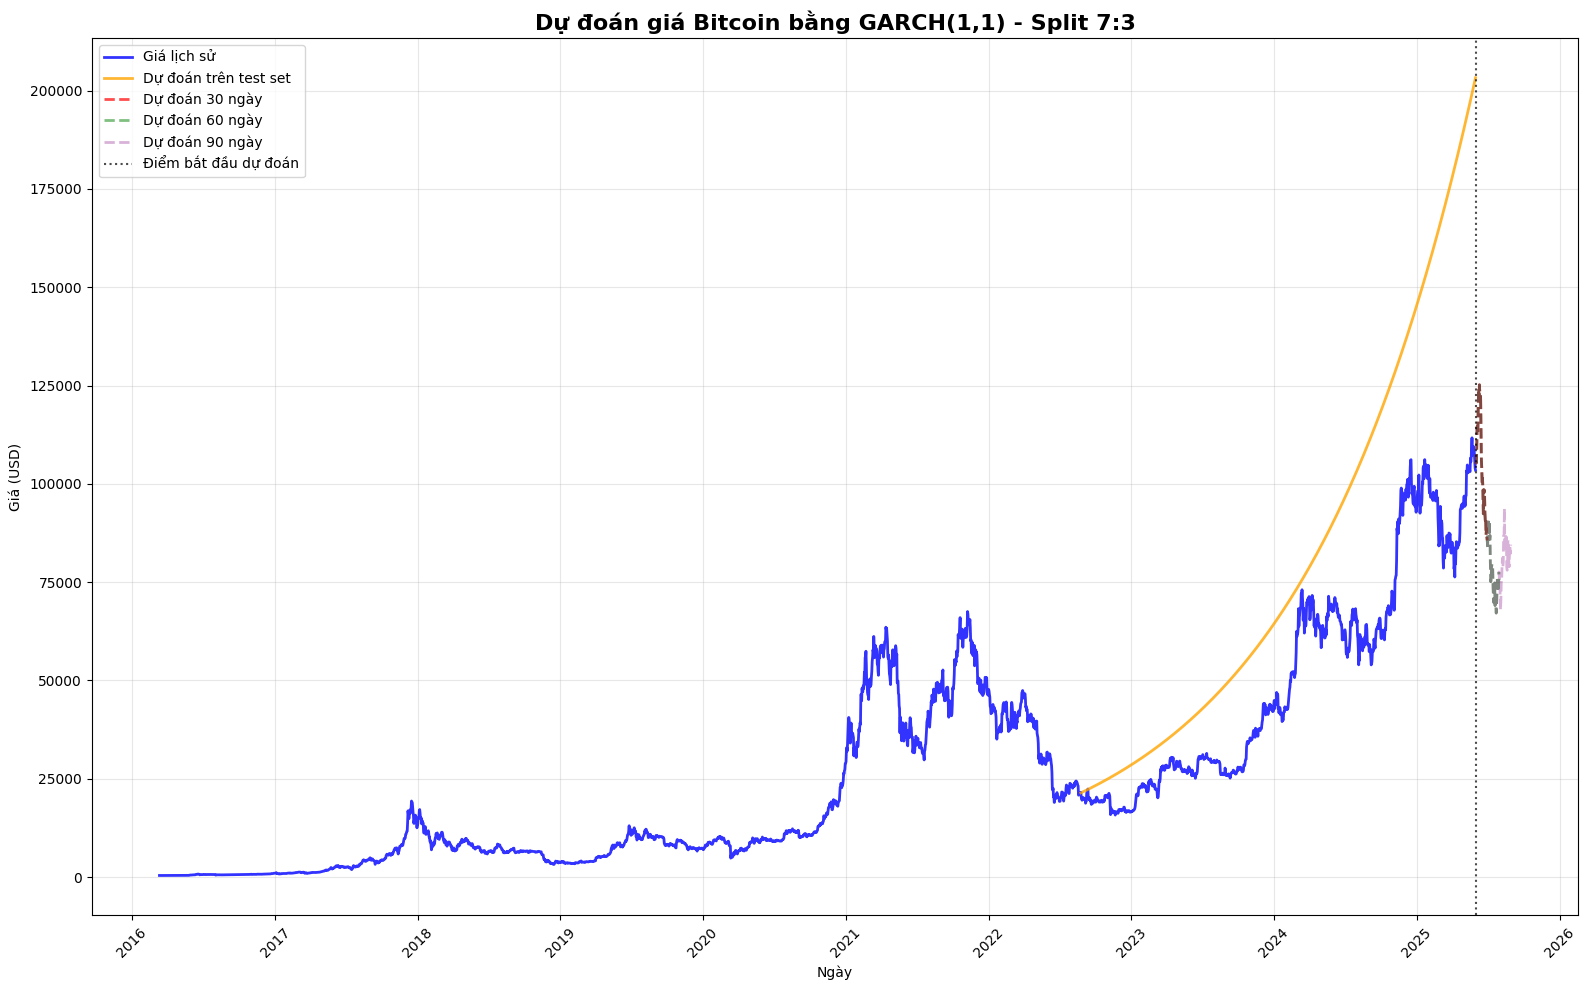

In [49]:
# Dự đoán 30, 60, 90 ngày tiếp theo
last_price = data_clean['Price'].iloc[-1]

# Forecast prices
forecast_30, vol_30 = forecast_garch_prices(fitted_garch, last_price, 30)
forecast_60, vol_60 = forecast_garch_prices(fitted_garch, last_price, 60)
forecast_90, vol_90 = forecast_garch_prices(fitted_garch, last_price, 90)

# Tạo dates cho forecasts
forecast_dates_30 = pd.date_range(start=data_clean.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_dates_60 = pd.date_range(start=data_clean.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
forecast_dates_90 = pd.date_range(start=data_clean.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

# Tạo DataFrames
forecast_df_30 = pd.DataFrame(forecast_30, index=forecast_dates_30, columns=['Price'])
forecast_df_60 = pd.DataFrame(forecast_60, index=forecast_dates_60, columns=['Price'])
forecast_df_90 = pd.DataFrame(forecast_90, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa
plt.figure(figsize=(16, 10))

# Vẽ dữ liệu lịch sử
plt.plot(data_clean.index, data_clean['Price'], label='Giá lịch sử', color='blue', linewidth=2, alpha=0.8)

# Vẽ dự đoán test
plt.plot(test_data.index, predicted_prices_test, label='Dự đoán trên test set', color='orange', linewidth=2, alpha=0.8)

# Vẽ dự đoán tương lai
plt.plot(forecast_df_30.index, forecast_df_30['Price'], 
         label='Dự đoán 30 ngày', color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(forecast_df_60.index, forecast_df_60['Price'], 
         label='Dự đoán 60 ngày', color='green', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(forecast_df_90.index, forecast_df_90['Price'], 
         label='Dự đoán 90 ngày', color='purple', linestyle='--', linewidth=2, alpha=0.3)

# Đường phân cách
plt.axvline(x=data_clean.index[-1], color='black', linestyle=':', alpha=0.7, 
            label='Điểm bắt đầu dự đoán')

plt.title('Dự đoán giá Bitcoin bằng GARCH(1,1) - Split 7:3', fontsize=16, fontweight='bold')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo (GARCH 7:3):')
print(f'Giá cao nhất: ${forecast_30.max():.2f}')
print(f'Giá thấp nhất: ${forecast_30.min():.2f}')
print(f'Giá trung bình: ${forecast_30.mean():.2f}')
print(f'Volatility trung bình: {vol_30.mean():.2f}%')


Dự đoán giá Bitcoin 30 ngày tiếp theo (GARCH 7:3):
Giá cao nhất: $125180.21
Giá thấp nhất: $85620.35
Giá trung bình: $105057.66
Volatility trung bình: 4.07%


### Chia 8:2


#### Chuẩn bị dữ liệu 8:2


In [51]:
# Sử dụng dữ liệu đã chuẩn bị ở trên (data_clean với Log_Return)
print(f"Sử dụng dữ liệu đã chuẩn bị: {len(data_clean)} dòng")

Sử dụng dữ liệu đã chuẩn bị: 3369 dòng


In [52]:
# Chia dữ liệu train/test theo tỷ lệ 8:2
train_size_82 = int(len(data_clean) * 0.8)
train_data_82 = data_clean.iloc[0:train_size_82].copy()
test_data_82 = data_clean.iloc[train_size_82:].copy()

# Lấy returns cho train và test
train_returns_82 = train_data_82['Log_Return'].values
test_returns_82 = test_data_82['Log_Return'].values

print(f"Kích thước tập train 8:2: {len(train_data_82)}")
print(f"Kích thước tập test 8:2: {len(test_data_82)}")

Kích thước tập train 8:2: 2695
Kích thước tập test 8:2: 674


#### Huấn luyện mô hình GARCH 8:2


In [53]:
# Fit mô hình GARCH(1,1) cho split 8:2
print("Đang huấn luyện mô hình GARCH(1,1) cho split 8:2...")
fitted_garch_82, garch_model_82 = build_garch_model(train_returns_82, p=1, q=1)

# Đánh giá mô hình
aic_82, bic_82 = evaluate_garch_model(fitted_garch_82)

Đang huấn luyện mô hình GARCH(1,1) cho split 8:2...
THÔNG TIN MÔ HÌNH GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7273.22
Distribution:                  Normal   AIC:                           14554.4
Method:            Maximum Likelihood   BIC:                           14578.0
                                        No. Observations:                 2695
Date:                Mon, Jun 02 2025   Df Residuals:                     2694
Time:                        15:33:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------------------

#### Đánh giá mô hình 8:2


In [54]:
# Dự đoán trên tập test 8:2
test_size_days_82 = len(test_data_82)
last_train_price_82 = train_data_82['Price'].iloc[-1]

# Forecast cho test period
test_forecast_82 = fitted_garch_82.forecast(horizon=test_size_days_82)
forecast_returns_82 = test_forecast_82.mean.iloc[-1].values / 100

# Tính predicted prices cho test set 8:2
predicted_prices_test_82 = []
current_price_82 = last_train_price_82

for i in range(test_size_days_82):
    predicted_return = forecast_returns_82[i]
    current_price_82 = current_price_82 * np.exp(predicted_return)
    predicted_prices_test_82.append(current_price_82)

predicted_prices_test_82 = np.array(predicted_prices_test_82)

# Tính metrics cho 8:2
actual_test_prices_82 = test_data_82['Price'].values
mape_82 = mean_absolute_percentage_error(actual_test_prices_82, predicted_prices_test_82)
mse_82 = mean_squared_error(actual_test_prices_82, predicted_prices_test_82)
rmse_82 = np.sqrt(mse_82)

print(f'Kết quả đánh giá mô hình GARCH(1,1) - Split 8:2:')
print(f'MAPE: {mape_82:.2f}%')
print(f'MSE: {mse_82:.2f}')
print(f'RMSE: {rmse_82:.2f}')
print(f'AIC: {aic_82:.2f}')
print(f'BIC: {bic_82:.2f}')

Kết quả đánh giá mô hình GARCH(1,1) - Split 8:2:
MAPE: 0.13%
MSE: 119564962.50
RMSE: 10934.58
AIC: 14554.44
BIC: 14578.03


#### Dự đoán tương lai 8:2


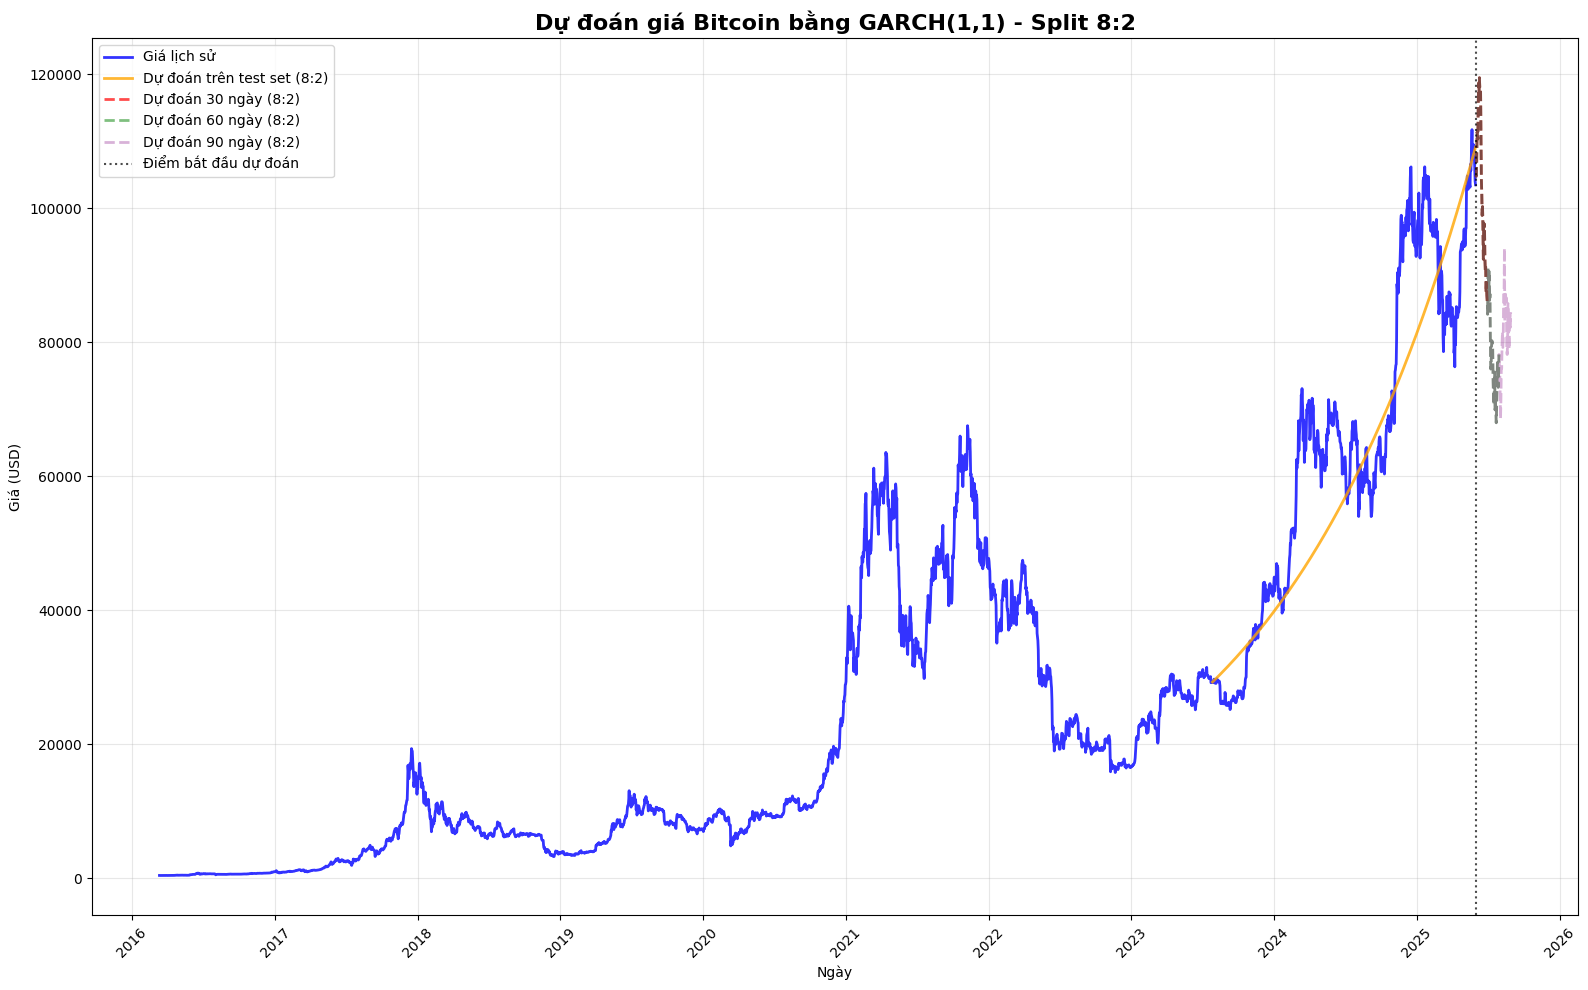


Dự đoán giá Bitcoin 30 ngày tiếp theo (GARCH 8:2):
Giá cao nhất: $119449.90
Giá thấp nhất: $86091.68
Giá trung bình: $103118.90
Volatility trung bình: 3.39%


In [55]:
# Dự đoán 30, 60, 90 ngày tiếp theo cho 8:2
forecast_30_82, vol_30_82 = forecast_garch_prices(fitted_garch_82, last_price, 30)
forecast_60_82, vol_60_82 = forecast_garch_prices(fitted_garch_82, last_price, 60)
forecast_90_82, vol_90_82 = forecast_garch_prices(fitted_garch_82, last_price, 90)

# Tạo DataFrames cho 8:2
forecast_df_30_82 = pd.DataFrame(forecast_30_82, index=forecast_dates_30, columns=['Price'])
forecast_df_60_82 = pd.DataFrame(forecast_60_82, index=forecast_dates_60, columns=['Price'])
forecast_df_90_82 = pd.DataFrame(forecast_90_82, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa 8:2
plt.figure(figsize=(16, 10))
plt.plot(data_clean.index, data_clean['Price'], label='Giá lịch sử', color='blue', linewidth=2, alpha=0.8)
plt.plot(test_data_82.index, predicted_prices_test_82, label='Dự đoán trên test set (8:2)', color='orange', linewidth=2, alpha=0.8)
plt.plot(forecast_df_30_82.index, forecast_df_30_82['Price'], 
         label='Dự đoán 30 ngày (8:2)', color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(forecast_df_60_82.index, forecast_df_60_82['Price'], 
         label='Dự đoán 60 ngày (8:2)', color='green', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(forecast_df_90_82.index, forecast_df_90_82['Price'], 
         label='Dự đoán 90 ngày (8:2)', color='purple', linestyle='--', linewidth=2, alpha=0.3)
plt.axvline(x=data_clean.index[-1], color='black', linestyle=':', alpha=0.7, 
            label='Điểm bắt đầu dự đoán')
plt.title('Dự đoán giá Bitcoin bằng GARCH(1,1) - Split 8:2', fontsize=16, fontweight='bold')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo (GARCH 8:2):')
print(f'Giá cao nhất: ${forecast_30_82.max():.2f}')
print(f'Giá thấp nhất: ${forecast_30_82.min():.2f}')
print(f'Giá trung bình: ${forecast_30_82.mean():.2f}')
print(f'Volatility trung bình: {vol_30_82.mean():.2f}%')

### Chia 9:1


#### Chuẩn bị dữ liệu 9:1


In [56]:
# Sử dụng dữ liệu đã chuẩn bị ở trên (data_clean với Log_Return)
print(f"Sử dụng dữ liệu đã chuẩn bị: {len(data_clean)} dòng")

Sử dụng dữ liệu đã chuẩn bị: 3369 dòng


In [57]:
# Chia dữ liệu train/test theo tỷ lệ 9:1
train_size_91 = int(len(data_clean) * 0.9)
train_data_91 = data_clean.iloc[0:train_size_91].copy()
test_data_91 = data_clean.iloc[train_size_91:].copy()

# Lấy returns cho train và test
train_returns_91 = train_data_91['Log_Return'].values
test_returns_91 = test_data_91['Log_Return'].values

print(f"Kích thước tập train 9:1: {len(train_data_91)}")
print(f"Kích thước tập test 9:1: {len(test_data_91)}")

Kích thước tập train 9:1: 3032
Kích thước tập test 9:1: 337


#### Huấn luyện mô hình GARCH 9:1


In [58]:
# Fit mô hình GARCH(1,1) cho split 9:1
print("Đang huấn luyện mô hình GARCH(1,1) cho split 9:1...")
fitted_garch_91, garch_model_91 = build_garch_model(train_returns_91, p=1, q=1)

# Đánh giá mô hình
aic_91, bic_91 = evaluate_garch_model(fitted_garch_91)

Đang huấn luyện mô hình GARCH(1,1) cho split 9:1...
THÔNG TIN MÔ HÌNH GARCH
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8062.68
Distribution:                  Normal   AIC:                           16133.4
Method:            Maximum Likelihood   BIC:                           16157.4
                                        No. Observations:                 3032
Date:                Mon, Jun 02 2025   Df Residuals:                     3031
Time:                        15:33:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------------------

#### Đánh giá mô hình 9:1


In [59]:
# Dự đoán trên tập test 9:1
test_size_days_91 = len(test_data_91)
last_train_price_91 = train_data_91['Price'].iloc[-1]

# Forecast cho test period
test_forecast_91 = fitted_garch_91.forecast(horizon=test_size_days_91)
forecast_returns_91 = test_forecast_91.mean.iloc[-1].values / 100

# Tính predicted prices cho test set 9:1
predicted_prices_test_91 = []
current_price_91 = last_train_price_91

for i in range(test_size_days_91):
    predicted_return = forecast_returns_91[i]
    current_price_91 = current_price_91 * np.exp(predicted_return)
    predicted_prices_test_91.append(current_price_91)

predicted_prices_test_91 = np.array(predicted_prices_test_91)

# Tính metrics cho 9:1
actual_test_prices_91 = test_data_91['Price'].values
mape_91 = mean_absolute_percentage_error(actual_test_prices_91, predicted_prices_test_91)
mse_91 = mean_squared_error(actual_test_prices_91, predicted_prices_test_91)
rmse_91 = np.sqrt(mse_91)

print(f'Kết quả đánh giá mô hình GARCH(1,1) - Split 9:1:')
print(f'MAPE: {mape_91:.2f}%')
print(f'MSE: {mse_91:.2f}')
print(f'RMSE: {rmse_91:.2f}')
print(f'AIC: {aic_91:.2f}')
print(f'BIC: {bic_91:.2f}')

Kết quả đánh giá mô hình GARCH(1,1) - Split 9:1:
MAPE: 0.13%
MSE: 136029586.18
RMSE: 11663.17
AIC: 16133.35
BIC: 16157.42


#### Dự đoán tương lai 9:1


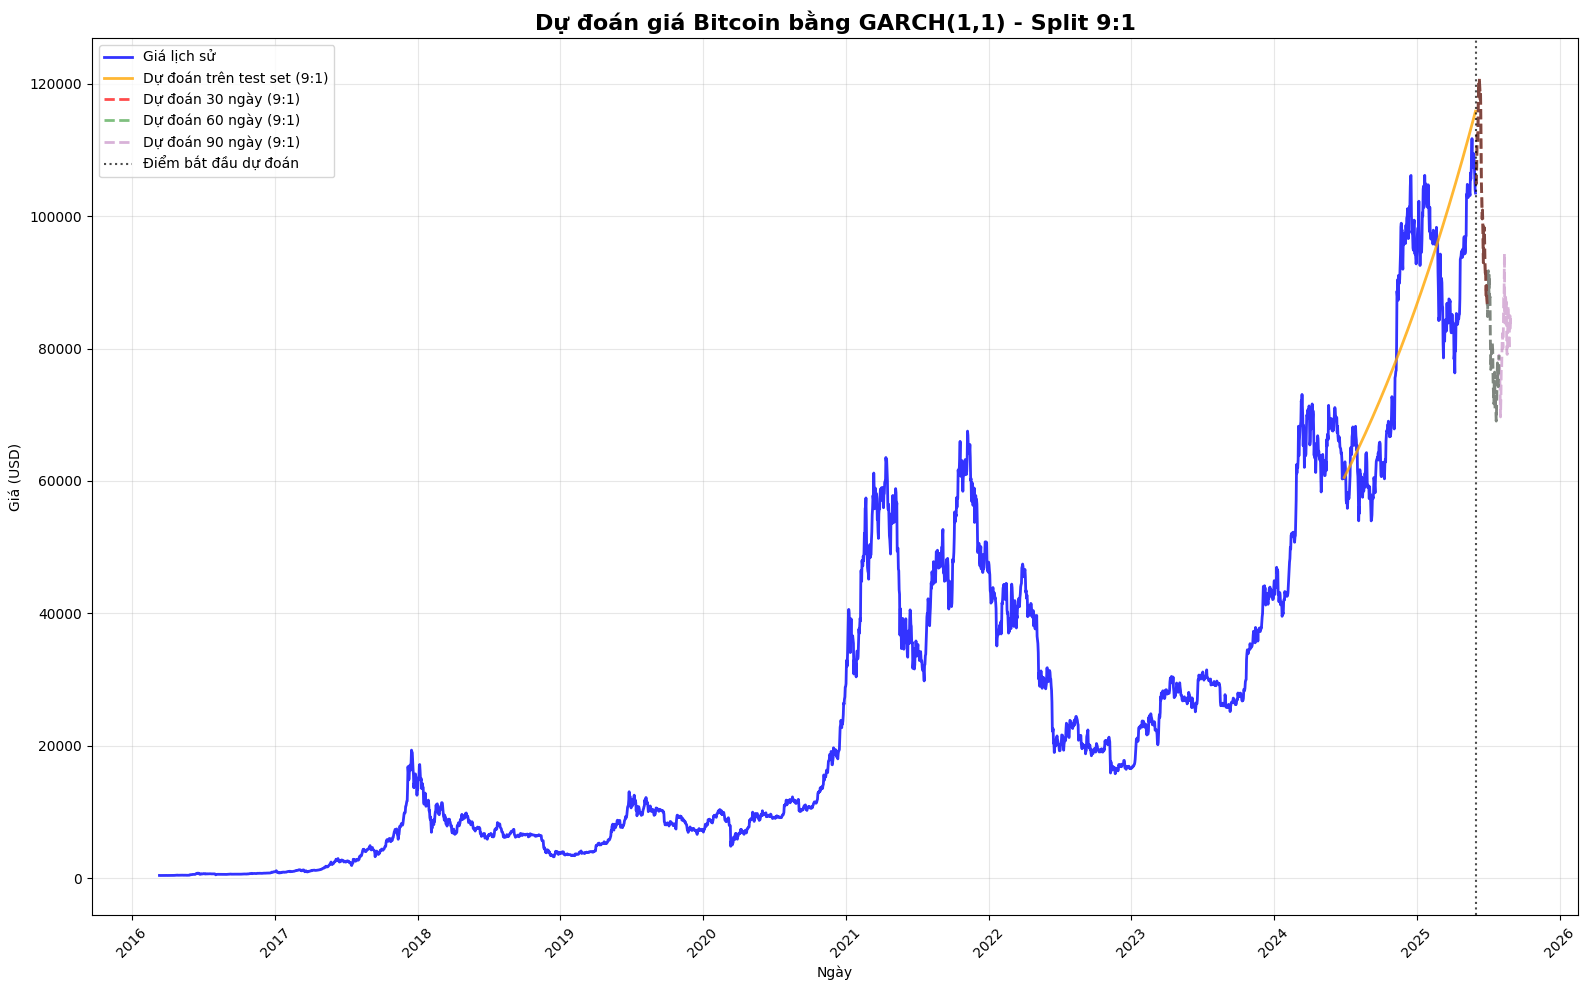


Dự đoán giá Bitcoin 30 ngày tiếp theo (GARCH 9:1):
Giá cao nhất: $120899.64
Giá thấp nhất: $86736.24
Giá trung bình: $103922.23
Volatility trung bình: 3.49%


In [60]:
# Dự đoán 30, 60, 90 ngày tiếp theo cho 9:1
forecast_30_91, vol_30_91 = forecast_garch_prices(fitted_garch_91, last_price, 30)
forecast_60_91, vol_60_91 = forecast_garch_prices(fitted_garch_91, last_price, 60)
forecast_90_91, vol_90_91 = forecast_garch_prices(fitted_garch_91, last_price, 90)

# Tạo DataFrames cho 9:1
forecast_df_30_91 = pd.DataFrame(forecast_30_91, index=forecast_dates_30, columns=['Price'])
forecast_df_60_91 = pd.DataFrame(forecast_60_91, index=forecast_dates_60, columns=['Price'])
forecast_df_90_91 = pd.DataFrame(forecast_90_91, index=forecast_dates_90, columns=['Price'])

# Trực quan hóa 9:1
plt.figure(figsize=(16, 10))
plt.plot(data_clean.index, data_clean['Price'], label='Giá lịch sử', color='blue', linewidth=2, alpha=0.8)
plt.plot(test_data_91.index, predicted_prices_test_91, label='Dự đoán trên test set (9:1)', color='orange', linewidth=2, alpha=0.8)
plt.plot(forecast_df_30_91.index, forecast_df_30_91['Price'], 
         label='Dự đoán 30 ngày (9:1)', color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(forecast_df_60_91.index, forecast_df_60_91['Price'], 
         label='Dự đoán 60 ngày (9:1)', color='green', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(forecast_df_90_91.index, forecast_df_90_91['Price'], 
         label='Dự đoán 90 ngày (9:1)', color='purple', linestyle='--', linewidth=2, alpha=0.3)
plt.axvline(x=data_clean.index[-1], color='black', linestyle=':', alpha=0.7, 
            label='Điểm bắt đầu dự đoán')
plt.title('Dự đoán giá Bitcoin bằng GARCH(1,1) - Split 9:1', fontsize=16, fontweight='bold')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'\nDự đoán giá Bitcoin 30 ngày tiếp theo (GARCH 9:1):')
print(f'Giá cao nhất: ${forecast_30_91.max():.2f}')
print(f'Giá thấp nhất: ${forecast_30_91.min():.2f}')
print(f'Giá trung bình: ${forecast_30_91.mean():.2f}')
print(f'Volatility trung bình: {vol_30_91.mean():.2f}%')

### So sánh 3 tỉ lệ GARCH


In [61]:
# So sánh chi tiết giữa 3 tỉ lệ chia dữ liệu cho GARCH
print("="*80)
print("SO SÁNH CHI TIẾT GIỮA 3 TỈ LỆ CHIA DỮ LIỆU - GARCH MODEL")
print("="*80)

# Thu thập thông tin từ 3 splits
garch_splits_info = {
    '7:3': {
        'train_size': len(train_data),
        'test_size': len(test_data),
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'aic': aic,
        'bic': bic,
        'avg_volatility': vol_30.mean()
    },
    '8:2': {
        'train_size': len(train_data_82),
        'test_size': len(test_data_82),
        'mape': mape_82,
        'mse': mse_82,
        'rmse': rmse_82,
        'aic': aic_82,
        'bic': bic_82,
        'avg_volatility': vol_30_82.mean()
    },
    '9:1': {
        'train_size': len(train_data_91),
        'test_size': len(test_data_91),
        'mape': mape_91,
        'mse': mse_91,
        'rmse': rmse_91,
        'aic': aic_91,
        'bic': bic_91,
        'avg_volatility': vol_30_91.mean()
    }
}

# In bảng so sánh GARCH
for split, info in garch_splits_info.items():
    print(f"\n{split} Split (GARCH):")
    print(f"  Kích thước train: {info['train_size']:,} mẫu")
    print(f"  Kích thước test: {info['test_size']:,} mẫu")
    print(f"  MAPE: {info['mape']:.2f}%")
    print(f"  MSE: {info['mse']:,.2f}")
    print(f"  RMSE: {info['rmse']:,.2f}")
    print(f"  AIC: {info['aic']:.2f}")
    print(f"  BIC: {info['bic']:.2f}")
    print(f"  Avg Volatility: {info['avg_volatility']:.2f}%")

SO SÁNH CHI TIẾT GIỮA 3 TỈ LỆ CHIA DỮ LIỆU - GARCH MODEL

7:3 Split (GARCH):
  Kích thước train: 2,358 mẫu
  Kích thước test: 1,011 mẫu
  MAPE: 0.55%
  MSE: 1,572,132,497.08
  RMSE: 39,650.13
  AIC: 12961.76
  BIC: 12984.82
  Avg Volatility: 4.07%

8:2 Split (GARCH):
  Kích thước train: 2,695 mẫu
  Kích thước test: 674 mẫu
  MAPE: 0.13%
  MSE: 119,564,962.50
  RMSE: 10,934.58
  AIC: 14554.44
  BIC: 14578.03
  Avg Volatility: 3.39%

9:1 Split (GARCH):
  Kích thước train: 3,032 mẫu
  Kích thước test: 337 mẫu
  MAPE: 0.13%
  MSE: 136,029,586.18
  RMSE: 11,663.17
  AIC: 16133.35
  BIC: 16157.42
  Avg Volatility: 3.49%


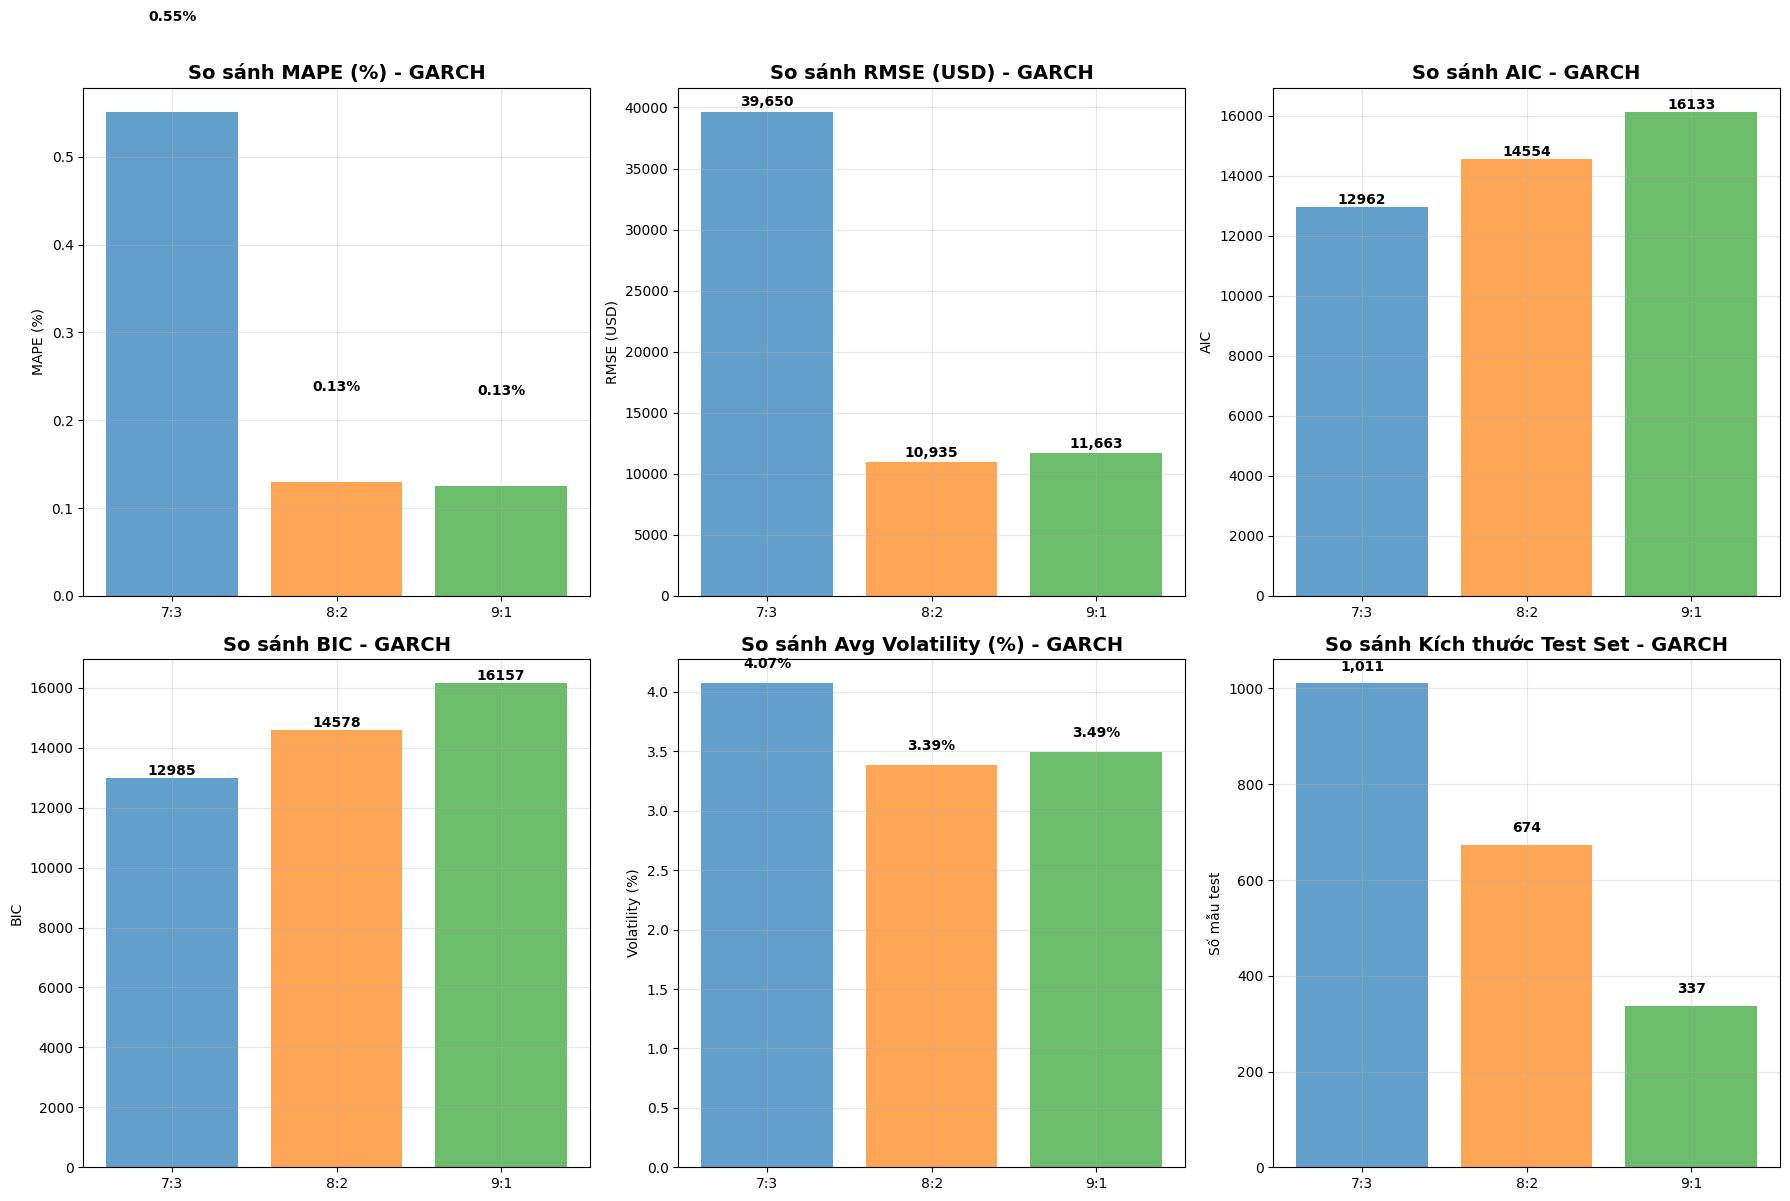

In [62]:
# Vẽ biểu đồ so sánh các metrics cho GARCH
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

splits = ['7:3', '8:2', '9:1']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# 1. So sánh MAPE
mape_values = [garch_splits_info[split]['mape'] for split in splits]
axes[0, 0].bar(splits, mape_values, color=colors, alpha=0.7)
axes[0, 0].set_title('So sánh MAPE (%) - GARCH', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('MAPE (%)')
axes[0, 0].grid(True, alpha=0.3)
for i, v in enumerate(mape_values):
    axes[0, 0].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. So sánh RMSE
rmse_values = [garch_splits_info[split]['rmse'] for split in splits]
axes[0, 1].bar(splits, rmse_values, color=colors, alpha=0.7)
axes[0, 1].set_title('So sánh RMSE (USD) - GARCH', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('RMSE (USD)')
axes[0, 1].grid(True, alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0, 1].text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# 3. So sánh AIC
aic_values = [garch_splits_info[split]['aic'] for split in splits]
axes[0, 2].bar(splits, aic_values, color=colors, alpha=0.7)
axes[0, 2].set_title('So sánh AIC - GARCH', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('AIC')
axes[0, 2].grid(True, alpha=0.3)
for i, v in enumerate(aic_values):
    axes[0, 2].text(i, v + 5, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 4. So sánh BIC
bic_values = [garch_splits_info[split]['bic'] for split in splits]
axes[1, 0].bar(splits, bic_values, color=colors, alpha=0.7)
axes[1, 0].set_title('So sánh BIC - GARCH', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('BIC')
axes[1, 0].grid(True, alpha=0.3)
for i, v in enumerate(bic_values):
    axes[1, 0].text(i, v + 5, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 5. So sánh Average Volatility
vol_values = [garch_splits_info[split]['avg_volatility'] for split in splits]
axes[1, 1].bar(splits, vol_values, color=colors, alpha=0.7)
axes[1, 1].set_title('So sánh Avg Volatility (%) - GARCH', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Volatility (%)')
axes[1, 1].grid(True, alpha=0.3)
for i, v in enumerate(vol_values):
    axes[1, 1].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 6. So sánh kích thước test set
test_sizes = [garch_splits_info[split]['test_size'] for split in splits]
axes[1, 2].bar(splits, test_sizes, color=colors, alpha=0.7)
axes[1, 2].set_title('So sánh Kích thước Test Set - GARCH', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Số mẫu test')
axes[1, 2].grid(True, alpha=0.3)
for i, v in enumerate(test_sizes):
    axes[1, 2].text(i, v + 20, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [63]:
# Tạo DataFrame tổng hợp kết quả GARCH
garch_comparison_df = pd.DataFrame({
    'Split': ['7:3', '8:2', '9:1'],
    'Train_Size': [garch_splits_info[split]['train_size'] for split in splits],
    'Test_Size': [garch_splits_info[split]['test_size'] for split in splits],
    'MAPE (%)': [garch_splits_info[split]['mape'] for split in splits],
    'RMSE (USD)': [garch_splits_info[split]['rmse'] for split in splits],
    'MSE': [garch_splits_info[split]['mse'] for split in splits],
    'AIC': [garch_splits_info[split]['aic'] for split in splits],
    'BIC': [garch_splits_info[split]['bic'] for split in splits],
    'Avg_Volatility (%)': [garch_splits_info[split]['avg_volatility'] for split in splits]
})

print("\nBẢNG TỔNG HỢP KẾT QUẢ GARCH:")
print("="*100)
print(garch_comparison_df.to_string(index=False, float_format='%.4f'))


BẢNG TỔNG HỢP KẾT QUẢ GARCH:
Split  Train_Size  Test_Size  MAPE (%)  RMSE (USD)             MSE        AIC        BIC  Avg_Volatility (%)
  7:3        2358       1011    0.5514  39650.1261 1572132497.0754 12961.7608 12984.8231              4.0730
  8:2        2695        674    0.1299  10934.5765  119564962.5033 14554.4358 14578.0325              3.3878
  9:1        3032        337    0.1255  11663.1722  136029586.1774 16133.3505 16157.4184              3.4942


In [64]:
# Phân tích và đưa ra khuyến nghị cho GARCH
print("\n" + "="*80)
print("PHÂN TÍCH VÀ KHUYẾN NGHỊ - GARCH MODEL")
print("="*80)

# Tìm split tốt nhất cho từng metric
best_mape_split_garch = splits[np.argmin([garch_splits_info[split]['mape'] for split in splits])]
best_rmse_split_garch = splits[np.argmin([garch_splits_info[split]['rmse'] for split in splits])]
best_aic_split_garch = splits[np.argmin([garch_splits_info[split]['aic'] for split in splits])]
best_bic_split_garch = splits[np.argmin([garch_splits_info[split]['bic'] for split in splits])]

print(f"\n1. PHÂN TÍCH THEO TỪNG TIÊU CHÍ (GARCH):")
print(f"   • Tốt nhất theo MAPE: {best_mape_split_garch} ({garch_splits_info[best_mape_split_garch]['mape']:.2f}%)")
print(f"   • Tốt nhất theo RMSE: {best_rmse_split_garch} ({garch_splits_info[best_rmse_split_garch]['rmse']:,.2f} USD)")
print(f"   • Tốt nhất theo AIC: {best_aic_split_garch} ({garch_splits_info[best_aic_split_garch]['aic']:.2f})")
print(f"   • Tốt nhất theo BIC: {best_bic_split_garch} ({garch_splits_info[best_bic_split_garch]['bic']:.2f})")

# Tính điểm tổng hợp cho GARCH
def calculate_garch_rank_score(splits_info):
    scores = {}
    splits_list = list(splits_info.keys())
    
    # Rank cho các metrics (thấp hơn = tốt hơn)
    mape_rank = sorted(splits_list, key=lambda x: splits_info[x]['mape'])
    rmse_rank = sorted(splits_list, key=lambda x: splits_info[x]['rmse'])
    aic_rank = sorted(splits_list, key=lambda x: splits_info[x]['aic'])
    bic_rank = sorted(splits_list, key=lambda x: splits_info[x]['bic'])
    
    for split in splits_list:
        # Điểm rank với trọng số cho GARCH
        score = (mape_rank.index(split) + 1) * 0.35 + \
                (rmse_rank.index(split) + 1) * 0.35 + \
                (aic_rank.index(split) + 1) * 0.15 + \
                (bic_rank.index(split) + 1) * 0.15
        scores[split] = score
    
    return scores

# Tính điểm tổng hợp
garch_scores = calculate_garch_rank_score(garch_splits_info)
best_overall_split_garch = min(garch_scores, key=garch_scores.get)

print(f"\n2. ĐIỂM TỔNG HỢP GARCH (trọng số: MAPE=35%, RMSE=35%, AIC=15%, BIC=15%):")
for split in garch_splits_info.keys():
    print(f"   • {split}: {garch_scores[split]:.2f} điểm")

print(f"\n3. KẾT LUẬN VÀ KHUYẾN NGHỊ GARCH:")
print(f"   🏆 MÔ HÌNH GARCH TỐT NHẤT: Split {best_overall_split_garch}")
print(f"   📊 Lý do:")
print(f"      - MAPE: {garch_splits_info[best_overall_split_garch]['mape']:.2f}%")
print(f"      - RMSE: {garch_splits_info[best_overall_split_garch]['rmse']:,.2f} USD")
print(f"      - AIC: {garch_splits_info[best_overall_split_garch]['aic']:.2f}")
print(f"      - BIC: {garch_splits_info[best_overall_split_garch]['bic']:.2f}")
print(f"      - Avg Volatility: {garch_splits_info[best_overall_split_garch]['avg_volatility']:.2f}%")
print(f"      - Tập test có {garch_splits_info[best_overall_split_garch]['test_size']:,} mẫu")

print(f"\n4. NHẬN XÉT VỀ GARCH MODEL:")
print("   • GARCH hiệu quả trong việc mô hình hóa volatility clustering")
print("   • Phù hợp với dữ liệu tài chính có tính heteroskedasticity")
print("   • Cung cấp forecast về volatility cùng với price prediction")
print("   • AIC và BIC giúp đánh giá model fit và complexity")

print(f"\n   ⚠️  LƯU Ý GARCH: Model này tập trung vào volatility modeling")
print(f"   và phù hợp cho short-term forecasting với dữ liệu có tính volatility cao như Bitcoin.")


PHÂN TÍCH VÀ KHUYẾN NGHỊ - GARCH MODEL

1. PHÂN TÍCH THEO TỪNG TIÊU CHÍ (GARCH):
   • Tốt nhất theo MAPE: 9:1 (0.13%)
   • Tốt nhất theo RMSE: 8:2 (10,934.58 USD)
   • Tốt nhất theo AIC: 7:3 (12961.76)
   • Tốt nhất theo BIC: 7:3 (12984.82)

2. ĐIỂM TỔNG HỢP GARCH (trọng số: MAPE=35%, RMSE=35%, AIC=15%, BIC=15%):
   • 7:3: 2.40 điểm
   • 8:2: 1.65 điểm
   • 9:1: 1.95 điểm

3. KẾT LUẬN VÀ KHUYẾN NGHỊ GARCH:
   🏆 MÔ HÌNH GARCH TỐT NHẤT: Split 8:2
   📊 Lý do:
      - MAPE: 0.13%
      - RMSE: 10,934.58 USD
      - AIC: 14554.44
      - BIC: 14578.03
      - Avg Volatility: 3.39%
      - Tập test có 674 mẫu

4. NHẬN XÉT VỀ GARCH MODEL:
   • GARCH hiệu quả trong việc mô hình hóa volatility clustering
   • Phù hợp với dữ liệu tài chính có tính heteroskedasticity
   • Cung cấp forecast về volatility cùng với price prediction
   • AIC và BIC giúp đánh giá model fit và complexity

   ⚠️  LƯU Ý GARCH: Model này tập trung vào volatility modeling
   và phù hợp cho short-term forecasting với dữ li